# Low-level vision: FSRCNN

In [ ]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-04-01 09:47:37.035631


## Super-resolution with CNN

### 1. What is super-resolution?

> **Image super-resolution is a technique which enhances an image quality in terms of spatial resolution.**
> 
> 1. **Low Resolution (LR) Image** : Pixel density within an image is small, hence it offers few details.
> 2. **High Resolution (HR) Image** : Pixel density within an image is large, hence it offers a lot of details.
>
> **Super-resolution** reconstructs a high-resolution image (with restored details) from a low-resolution image.

<img src="https://docs.google.com/uc?export=download&id=1gBsghghJw7JTeRhp3D2drGqLsOtnVTri" alt="no_image" style="width: 900px;"/>

### 2. Why deep learning?

> **Learning based methods outperform simple interpolations or hand-designed methods.**
>
> 1. **Simple Interpolations** : Easy to implement (e.g., bicubic), but give poor visual quality, since the details are hard to be preserved.
> 2. **Hand-designed methods** : Involve several steps (e.g., sparse coding and dictionary learning), but not all of them can be optimized.
> 3. **Deep learning (CNN)** : Steps in the hand-designed methods can be combined into one big step with all of its parts being optimizable.
> 
<img src="https://docs.google.com/uc?export=download&id=1cDMjb9MWBzk4QvNDgQfSs94NfXacTKem" alt="no_image" style="width: 900px;"/>

### 3. SRCNN and FSRCNN

> **One of the pioneering works using CNNs to solve the super-resolution task.**
> 
> 1. **SRCNN**
>> - Starts with a bicubic-upsampled image.
>> - Convolutions are performed to improve a quality of the image.
>
> 2. **FSRCNN**
>> - Starts with a low-resolution image. (Hence faster.)
>> - Convolutions are performed in low-resolution spaces followed by a deconvolution which enhances spatial resolution.
>
>
> 

<img src="https://docs.google.com/uc?export=download&id=1vARLxgJpZjSebNn64Tj82gavEO31upGH" alt="no_image" style="width: 900px;"/>

### 4. Deconvolution ($\equiv$Transposed Convolution)
> 1. **How to do deconvolution?**
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1Yp507Xsmeo4Pv_lhw-3ZFuswc5gykc6z" alt="no_image" style="width: 400px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1070666mtaV6DhlfpDm4Z4a9KUtwPe1Pm" alt="no_image" style="width: 400px;"/> </td>
>> </tr></table>
>>
>> Given a $4\times4$ input, we can generate a $6\times6$ output by using a $3\times3$ filter. <br>
>> (Blue plane : Input feature map.  //  Green plane : Output feature map.) <br>
>> **Warning! : It is not an actual deconvolution!** It just mimics the deconvolution by filter learning. <br>
>> (We suggest you to use the terminology **"transposed convolution"** instead.)
>
> 2. **Why is it called as transposed convolution?**
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=17iV0lLh1BOf6pvndoYdp1LDdi-2cQk6k" alt="no_image" style="width: 400px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1azGuyIfrpIGbLJwgtO9qtpmL_ph_8Hbg" alt="no_image" style="width: 400px;"/> </td>
>> </tr></table>
>>
>> In order to generate a single pixel in the output, the input pixels are aggregated by **flipped** version of the filter (see the difference between left & right figures above).
>>
>> <font color="green"> The reason why we call convolving with **flipped** filter as a **transposed** convolution is described here: <br>
>> https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0. <br>
>> TL;DR : When we define a convolution operation by a matrix multiplication between a filter matrix and an input vector, then going backward (i.e., generating an input from an output) can be expressed by a matrix multiplication between **transpose** of the filter matrix and an output vector. </font>
>
> 3. **How to interpret it as a convolution?**
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1tpm6yJ3BKUNnqxlN-5NQjVbS_RXGjl8A" alt="no_image" style="width: 400px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1AGbz3sH8AXtUI8fJQQNtkMYCqsKeVb1s" alt="no_image" style="width: 400px;"/> </td>
>> </tr></table>
>>
>> `Conv2d` with **flipped** filter, given that **(filter size - 1) zeros are padded along borders** <br>$\equiv$ `ConvTranspose2d` with **no padding**
>
> 4. **Then, what does the padding mean in the transposed convolution?**
>> <img src="https://docs.google.com/uc?export=download&id=17XWdjYc4zlvVuKgKITSHg-k-t9aFkRgc" alt="no_image" style="width: 850px;"/>
>> It is not an actual padding. It works reversely, that is, it decreases the spatial size of the output.
>>
>> <font color="green"> Note. On the other hand, the argument `output_padding` in `ConvTranspose2d` increases the spatial size of the output. <br>
>> See https://pytorch.org/docs/master/nn.html#torch.nn.ConvTranspose2d for details. </font>
>
> 5. **Lastly, how does a stride work in the transposed convolution?**
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1OXw1wpJu3h0-KBhIaJOrPkCM_AvcK97s" alt="no_image" style="width: 400px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1Z6LswMASPdCyKqTJbi8zf9MCQp4n5WX7" alt="no_image" style="width: 400px;"/> </td>
>> </tr></table>
>>
>> The stride is applied on the output space. It mainly determines a factor of increasing. <br>
>> We can interpret it as a `Conv2d` with **flipped** filter, given that **(stride - 1) zeros are padded between input pixels**.

### 5. Implementing FSRCNN

> 1. **Dataset**
>> - 91-image dataset.
>> - Augmented with scaling / roatation / flipping.
>> - Use only Y channel of YCbCr color space.
>> - 64x64 HR image patches.
>> - Scaling factor = 4.
>
> 2. **Network architecture**
>> - FSRCNN (d,s,m) = (56,12,4). Convolutional filter sizes are specified in the figure above.
>> - PReLU activations.
>> - Deconvolution at the last layer (without activation). <br>
>>   The input resolution is $16\times16$ and the output resolution is $64\times64$, in case of scale factor 4.<br>
>>   You should find propoer  arguments (`padding`, `stride`, and `output_padding`) for `ConvTranspose2d`.
>
> 3. **Loss function**
>> - Mean squared error (MSE) loss between estimation & ground-truth: <br>
     ${1\over N} \sum^{N}_{i=1} \lVert F(Y^{i};\theta) - X^{i} \rVert^{2}_{2}$.
>
> 4. **Training**
>> - Weight initialization. <br>
>>   Convolutional weights : ~ $N(0,0.02^2)$ (Different from the paper, but for simplicity). <br>
>>   Convolutional biases : Zero initialization. <br>
>>   Deconvolutional weights : ~ $N(0,0.001^2)$. <br>
>>   Deconvolutional biases : Zero initialization.
>> - Learning rate. <br>
>>   Convolutional parameters : $10^{-3}$. <br>
>>   Deconvolutional parameters : $10^{-4}$.
>> - Optimizer. <br>
>>   Adam optimizer with default parameters ($\beta_{1} = 0.9, \beta_{2} = 0.999$). <br>
>>   (Note. The paper proposes to use the SGD optimizer, but using the Adam optimizer shows faster convergence.)
>> - 51 epochs without learning rate scheduling.
>
> 4. **Evaluation metric**
>> - Peak Signal-to-Noise Ratio (PSNR) : $10 \log_{10} \left( MAX_{I} \over MSE  \right)$.
>> - Measured with Y channel of images.
>
> 

### *References*
[1] https://cv-tricks.com/deep-learning-2/image-super-resolution-to-enhance-photos/ <br>
[2] https://deepsense.ai/using-deep-learning-for-single-image-super-resolution/ <br>
[3] Dong et al., "Learning a deep convolutional network for image super-resolution", *ECCV*, 2014. <br>
[4] Dong et al., "Accelerating the super-resolution convolutional neural network", *ECCV*, 2016. <br>
[5] https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8 <br>
[6] https://pytorch.org/docs/master/nn.html#torch.nn.ConvTranspose2d

## FSRCNN with PyTorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt

from misc.lab05.imresize import imresize
import numpy as np
import skimage
import os
import glob
from skimage.io import imread
import skimage

os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Generating training patches (Do NOT run this cell)

In [ ]:
# T91_directory = "../dataset/lab05/T91/"
# T91_images = sorted(glob.glob(T91_directory + "*.png"))

# print("The number of training images : ",len(T91_images))

# # Augmentation setting
# SCALE = [1, 0.9, 0.8, 0.7, 0.6, 2]
# ROTATION = [0,1,2,3]
# FLIP = [True,False]
# PATCH_SIZE = 64
# STRIDE = 64
# IS_GRAY = True
# HR_SET = []

# def load_img(filepath, is_gray):
#     img = imread(filepath)
#     ch = img.ndim
#     if ch == 2:
#         img = skimage.color.gray2rgb(img)
#     if is_gray:    
#         img = skimage.color.rgb2ycbcr(img)
#     return img / 255.

# for idx in range(len(T91_images)):
#     print("\r Processing ", idx+1," / ",len(T91_images), end = '')
#     image_directory = T91_images[idx]
#     for f in FLIP:
#         for r in ROTATION:
#             for s in SCALE:
#                  # load image
#                 image = load_img(image_directory, IS_GRAY) # is_gary : YCbCr or RGB
#                  # flipping
#                 if f:
#                     image = np.fliplr(image)
#                  # rotation
#                 image = np.rot90(image, k=r, axes=(0,1))
#                  # scaling
#                 image = imresize(image, scalar_scale = s)
#                 image = image.clip(0,1)
#                 # generate HR patch
#                 h,w,_ = image.shape
#                 for i in range(0, h-PATCH_SIZE, STRIDE):
#                     for j in range(0, w-PATCH_SIZE, STRIDE):
#                         hr_patch = image[i:i+PATCH_SIZE, j:j+PATCH_SIZE, :]
#                         if IS_GRAY:
#                             hr_patch = hr_patch[:,:,0]
#                         HR_SET.append(hr_patch)

# print("\nThe number of training patches : ",len(HR_SET))
# np.save('../dataset/lab05/HR_patches_from_T91.npy', HR_SET)
# print("Training patches are successfully saved")

### Data loader

In [ ]:
print('STEP 1: DEFINE DATASET')

class T91_images(Dataset):
    def __init__(self, data_dir = "../dataset/lab05/HR_patches_from_T91.npy", HR_patch_size = 64, scale_factor = 4):
        super(T91_images, self).__init__()
        self.HR_patches_np = np.load(data_dir) # pre-processed patches
        self.HR_patch_size = HR_patch_size
        self.scale_factor = scale_factor
        
    def __getitem__(self, idx):
        HR_patch_np = self.HR_patches_np[idx] # high resolution patch
        LR_patch_np = imresize(HR_patch_np, scalar_scale = 1.0 / self.scale_factor) # low resolution patch
        BC_patch_np = imresize(LR_patch_np, scalar_scale = self.scale_factor) # bicubic upsampled patch
        
        HR_patch = torch.from_numpy(HR_patch_np).type(torch.FloatTensor)
        LR_patch = torch.from_numpy(LR_patch_np).type(torch.FloatTensor)
        BC_patch = torch.from_numpy(BC_patch_np).type(torch.FloatTensor)
        
        HR_patch = HR_patch.unsqueeze(0) # size : 1(c) x 64(h) x 64(w)
        LR_patch = LR_patch.unsqueeze(0) # size : 1(c) x 16(h) x 16(w)
        BC_patch = BC_patch.unsqueeze(0) # size : 1(c) x 64(h) x 64(w)
                                
        return HR_patch, LR_patch, BC_patch # Y-channel patches
    
    def __len__(self):
        return len(self.HR_patches_np)
    
class Set5(Dataset):
    def __init__(self, data_dir = '../dataset/lab05/Set5/', scale_factor=4):
        super(Set5, self).__init__()
        self.image_filenames = [os.path.join(data_dir, x) for x in sorted(os.listdir(data_dir))]
        self.scale_factor = scale_factor

    def load_img(self, filepath):
        img = skimage.io.imread(filepath)
        ch = img.ndim
        if ch == 2:
            img = skimage.color.gray2rgb(img)
        img = skimage.color.rgb2ycbcr(img)

        return img / 255.
    
    def calculate_valid_crop_size(self, crop_size, scale_factor):
        return crop_size - (crop_size % scale_factor)
    
    def __getitem__(self, idx):
        # load image
        img_np = self.load_img(self.image_filenames[idx])
        
        # original HR image size
        h, w, _ = img_np.shape
                
        # determine valid HR image size with scale factor
        HR_img_w = self.calculate_valid_crop_size(w, self.scale_factor)
        HR_img_h = self.calculate_valid_crop_size(h, self.scale_factor)

        # determine lr_img LR image size
        LR_img_w = HR_img_w // self.scale_factor
        LR_img_h = HR_img_h // self.scale_factor

        HR_img_np = img_np[:HR_img_h,:HR_img_w,:] # high resolution image
        LR_img_np = imresize(HR_img_np, scalar_scale = 1.0/self.scale_factor) # low resolution image
        BC_img_np = imresize(LR_img_np, scalar_scale = self.scale_factor) # bicubic upsampled image
        
        HR_img = torch.from_numpy(HR_img_np).type(torch.FloatTensor).permute(2,0,1) # size : 3(c) x h x w
        LR_img = torch.from_numpy(LR_img_np).type(torch.FloatTensor).permute(2,0,1) # size : 3(c) x (h/scale_factor) x (w/scale_factor)
        BC_img = torch.from_numpy(BC_img_np).type(torch.FloatTensor).permute(2,0,1) # size : 3(c) x h x w
        
        return HR_img, LR_img, BC_img # YCbCr images

    def __len__(self):
        return len(self.image_filenames)

STEP 1: DEFINE DATASET


In [ ]:
print('STEP 2: LOADING DATASET')

scale_factor = 4 # 1/4 down scaling

train_dataset = T91_images(data_dir = "../dataset/lab05/HR_patches_from_T91.npy", HR_patch_size = 64, scale_factor = scale_factor)
test_dataset = Set5(data_dir = "../dataset/lab05/Set5/", scale_factor = scale_factor)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = 64, 
                                           shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                          batch_size = 1, 
                                          shuffle = False)

STEP 2: LOADING DATASET


In [ ]:
print(test_dataset[0][1].shape)
print(test_dataset[0][1][0,:,:].reshape(1,1,128,128).shape)
print(len(test_loader))

torch.Size([3, 128, 128])
torch.Size([1, 1, 128, 128])
5


### Visualize a training sample

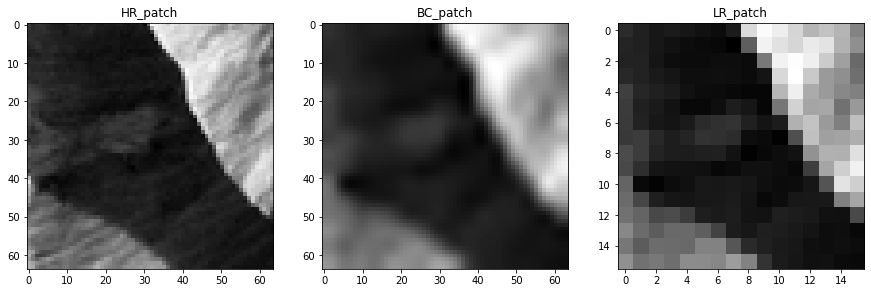

In [ ]:
(HR_patch, LR_patch, BC_patch) = train_dataset[100]
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.imshow(HR_patch.squeeze(0).numpy(), cmap='gray')
ax1.set_title("HR_patch")
ax2.imshow(BC_patch.squeeze(0).numpy(), cmap='gray')
ax2.set_title("BC_patch")
ax3.imshow(LR_patch.squeeze(0).numpy(), cmap='gray')
ax3.set_title("LR_patch")
plt.show()

### 1.1 Write codes for the model (FSRCNN) [4 points]

In [ ]:
print('STEP 3: CREATE MODEL CLASS (FSRCNN)')

# FSRCNN (d,s,m) = (56,12,4) 
# -> 처음 input을 뽑는 채널 수 : 56
# -> 56의 채널 수를 1*1 filter를 이용하여 12개로 줄임
# -> 3*3 filter는 4번 사용함

# Conv(filter size, output 채널, input 채널)
# patch extraction Conv( 5, 56, 1)
# shrinking Conv(1, 12, 56)
# mapping Conv(3, 12, 12) 4번
# expanding Conv(1, 56, 12)

class FSRCNN(nn.Module):
    def __init__(self, scale_factor = 4):
        super(FSRCNN, self).__init__()
        
        d = 56
        s = 12
        
        # Feature extraction
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, d, kernel_size=5, padding=2),
            nn.PReLU()
        )
        
        # shrinking
        self.shrinking = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU()
        )
        
        # non-linear mapping
        self.non_lin_mapping = nn.Sequential(
            nn.Conv2d(s, s, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(s, s, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(s, s, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(s, s, kernel_size=3, padding=1),
            nn.PReLU()
        )
        
        # expanding
        self.expanding = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU()
        )
        
        # deconv
        self.deconvolution = nn.ConvTranspose2d(d, 1, kernel_size=9, stride=scale_factor, padding=4, output_padding = scale_factor-1)
            
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean = 0.0, std = 0.02)
#                 nn.init.kaiming_normal_(m.weight.data, a=0.25) # for SGD
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight.data, mean = 0.0, std = 0.001)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    
    def forward(self, LR_patch):
        x = self.feature_extraction(LR_patch)
        x = self.shrinking(x)
        x = self.non_lin_mapping(x)
        x = self.expanding(x)
        output = self.deconvolution(x)
        
        return output

STEP 3: CREATE MODEL CLASS (FSRCNN)


In [ ]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = FSRCNN(scale_factor = scale_factor)
model.weight_init()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

#######################
#  USE GPU FOR MODEL  #
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  12644


FSRCNN(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=1)
  )
  (shrinking): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (non_lin_mapping): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=1)
  )
  (expanding): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (deconvolution): ConvTranspose2d(56, 1, kernel_size=(9, 9), stride=(4, 4), padding=(4, 4), output_padding=(3, 3))
)

In [ ]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

lr_conv = 1e-3
lr_deconv = 1e-4
# momentum = 0.9

param_conv = list(model.feature_extraction.parameters())+\
             list(model.shrinking.parameters())+\
             list(model.non_lin_mapping.parameters())+\
             list(model.expanding.parameters())

param_deconv = model.deconvolution.parameters()

# optimizer = torch.optim.SGD([{'params':param_conv},
#                              {'params':param_deconv, 'lr':lr_deconv}],
#                              lr = lr_conv, momentum = momentum)

optimizer = torch.optim.Adam([{'params':param_conv}, 
                             {'params':param_deconv, 'lr':lr_deconv}],
                             lr = lr_conv)

STEP 5: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the FSRCNN model and print PSNR for every epochs [4 points]

In [ ]:
import time
print('STEP 6: INSTANTIATE LOSS CLASS')
#############
criterion = nn.MSELoss()
#############


print('STEP 7: TRAIN THE MODEL')

if not os.path.exists("./weights/"):
    os.mkdir("./weights/")

if not os.path.exists("./weights/lab05/"):
    os.mkdir("./weights/lab05/")

num_epochs = 51

def PSNR(pred, gt, s = 0): # input images : 0~1 normalized / s : scale factor
    if pred.is_cuda:
        pred = pred.cpu()
    if gt.is_cuda:
        gt = gt.cpu()
    pred = pred[:,:,s:-s,s:-s] # shave border
    gt = gt[:,:,s:-s,s:-s]
    pred = pred.clamp(0, 1)
    diff = pred - gt
    mse = np.mean(diff.numpy() ** 2)
    if mse == 0:
        return 100
    return 10 * np.log10(1.0 / mse)

for epoch in range(num_epochs):
    # training stage
    model.train()
    total_loss = 0
    start = time.time()
    for i, (HR_patch, LR_patch, BC_patch) in enumerate(train_loader):
        #############
        optimizer.zero_grad()
        LR_patch = LR_patch.to(device)
        HR_patch = HR_patch.to(device)
        BC_patch = BC_patch.to(device)
        outputs = model(LR_patch)
        loss = criterion(outputs, HR_patch)
        loss.backward()
        optimizer.step()
        #############
        
        
    # test stage
    end = time.time()
    model.eval()
    
    # Calculate PSNR
    total_psnr = 0
    total_psnr_bic = 0
    # Iterate through test dataset
    with torch.no_grad():
        for (HR_img, LR_img, BC_img) in test_loader:
            #############
            LR_img = LR_img.to(device)
            LR_img_w = LR_img.shape[2]
            LR_img_h = LR_img.shape[3]
            LR_img = LR_img[0,0,:,:].reshape(1,1,LR_img_w,LR_img_h)
            
            HR_img = HR_img.to(device)
            HR_img_w = HR_img.shape[2]
            HR_img_h = HR_img.shape[3]
            HR_img = HR_img[0,0,:,:].reshape(1,1,HR_img_w,HR_img_h)

            BC_img = BC_img.to(device)
            BC_img_w = BC_img.shape[2]
            BC_img_h = BC_img.shape[3]
            BC_img = BC_img[0,0,:,:].reshape(1,1,BC_img_w,BC_img_h)
            
            output = model(LR_img)
            total_loss += criterion(output, HR_img)
            total_psnr += PSNR(output, HR_img, s = scale_factor)
            total_psnr_bic += PSNR(BC_img, HR_img, s = scale_factor)
        
        total_psnr /= len(test_loader) 
        total_psnr_bic /= len(test_loader)    
        # Print Loss
        print('Epochs: {0}. Loss: {1:.6f}. PSNR: {2:.3f} (bicubic)\t{3:.3f} (FSRCNN)\tElapsed time: {4} sec'.format(epoch, total_loss / (i+1), total_psnr_bic, total_psnr, end-start))
            
    
    # save weights
    if epoch % 5 == 0 and epoch != 0:
        torch.save({'state_dict':model.state_dict()},'./weights/lab05/checkpoint_%03d.pkl'%(epoch))

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.000022. PSNR: 28.432 (bicubic)	25.612 (FSRCNN)	Elapsed time: 22.331787109375 sec
Epochs: 1. Loss: 0.000018. PSNR: 28.432 (bicubic)	26.508 (FSRCNN)	Elapsed time: 22.820141315460205 sec
Epochs: 2. Loss: 0.000015. PSNR: 28.432 (bicubic)	26.835 (FSRCNN)	Elapsed time: 22.707253217697144 sec
Epochs: 3. Loss: 0.000011. PSNR: 28.432 (bicubic)	28.552 (FSRCNN)	Elapsed time: 22.537283182144165 sec
Epochs: 4. Loss: 0.000015. PSNR: 28.432 (bicubic)	26.252 (FSRCNN)	Elapsed time: 21.848952054977417 sec
Epochs: 5. Loss: 0.000010. PSNR: 28.432 (bicubic)	28.668 (FSRCNN)	Elapsed time: 22.188534021377563 sec
Epochs: 6. Loss: 0.000010. PSNR: 28.432 (bicubic)	28.949 (FSRCNN)	Elapsed time: 22.478644371032715 sec
Epochs: 7. Loss: 0.000010. PSNR: 28.432 (bicubic)	29.099 (FSRCNN)	Elapsed time: 23.16022253036499 sec
Epochs: 8. Loss: 0.000009. PSNR: 28.432 (bicubic)	29.160 (FSRCNN)	Elapsed time: 22.459681034088135 sec
Epochs: 9. Loss: 0.000

### 1.3 Visualize and compare test examples (RGB color) [2 points]

In [ ]:
def ycbcr2rgb(im): # input image : ranges from 0 to 255
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [ ]:
for (HR_img, LR_img, BC_img) in test_loader:
    print((HR_img*255).squeeze(0).shape)
    print((HR_img*255).squeeze(0).permute(1,2,0).shape)
    

torch.Size([3, 512, 512])
torch.Size([512, 512, 3])
torch.Size([3, 288, 288])
torch.Size([288, 288, 3])
torch.Size([3, 256, 256])
torch.Size([256, 256, 3])
torch.Size([3, 280, 280])
torch.Size([280, 280, 3])
torch.Size([3, 344, 228])
torch.Size([344, 228, 3])


/tmp/ipykernel_151260/1526198428.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = im.astype(np.float)


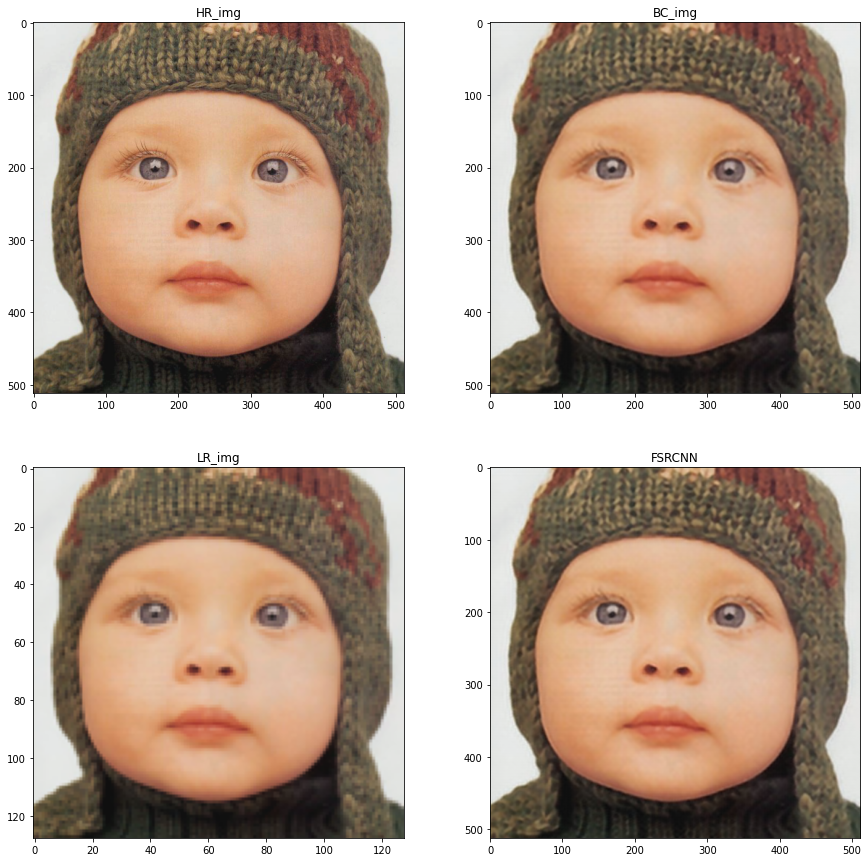

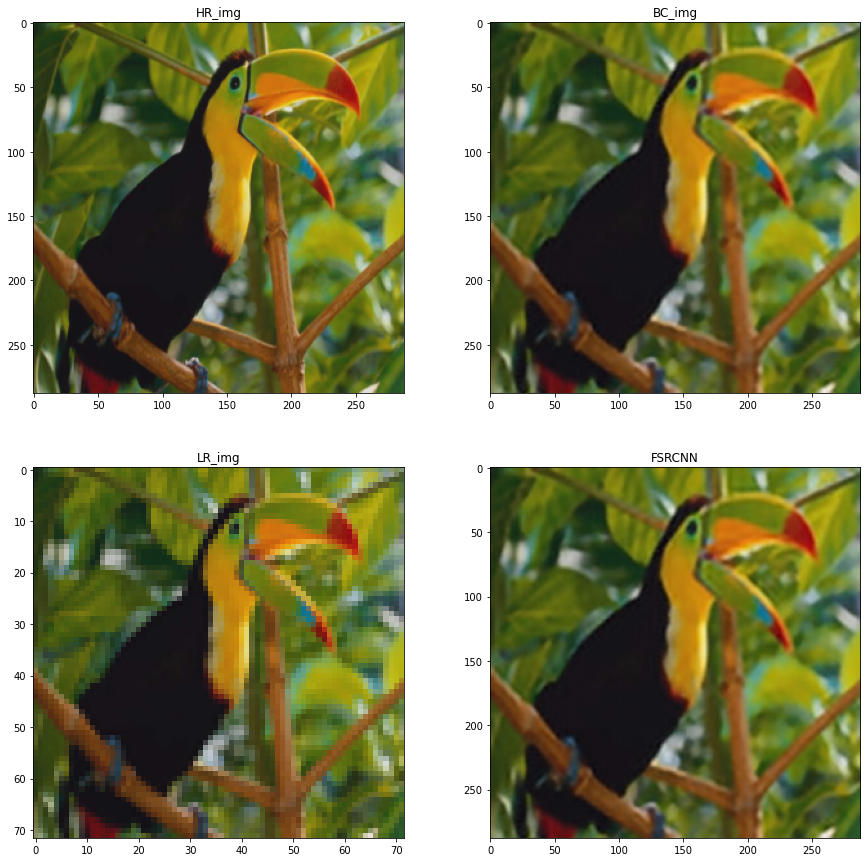

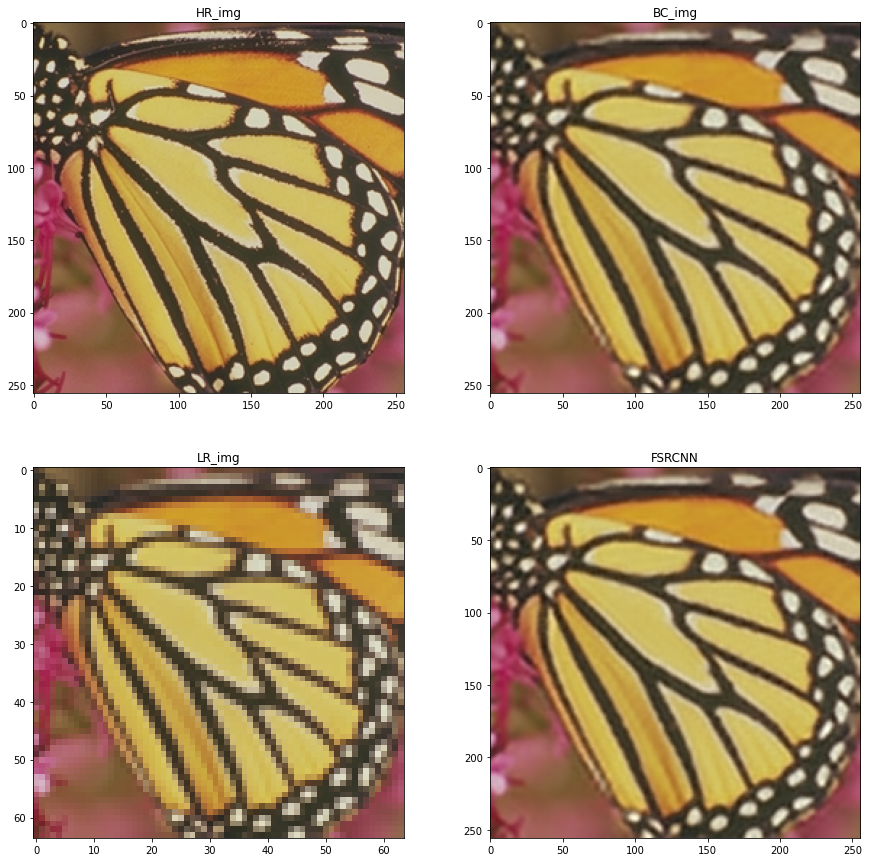

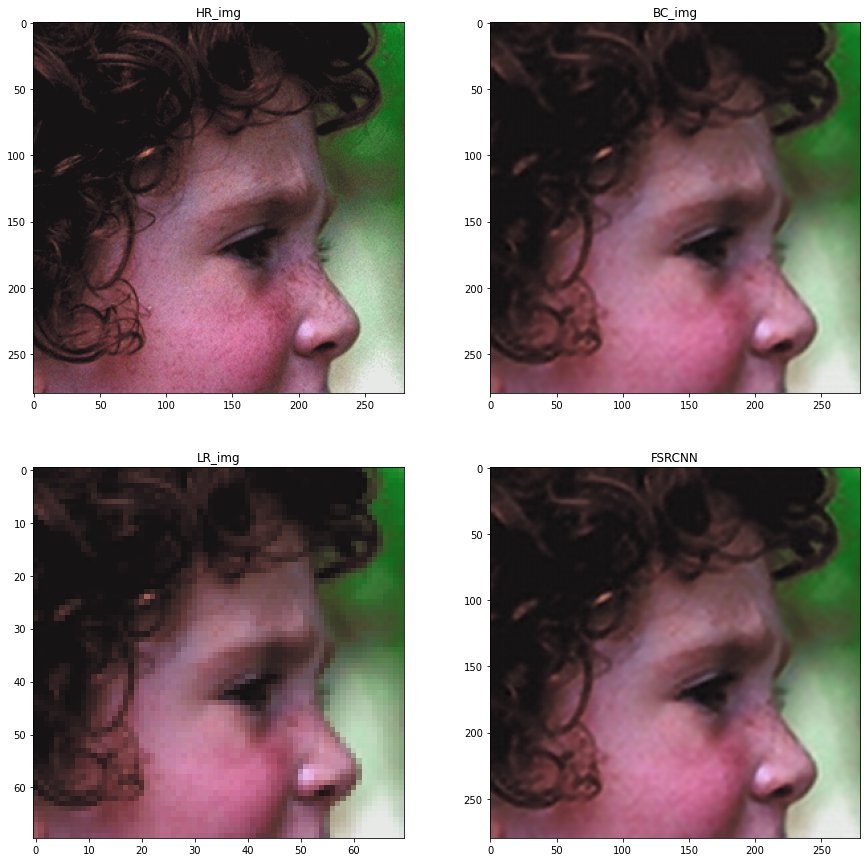

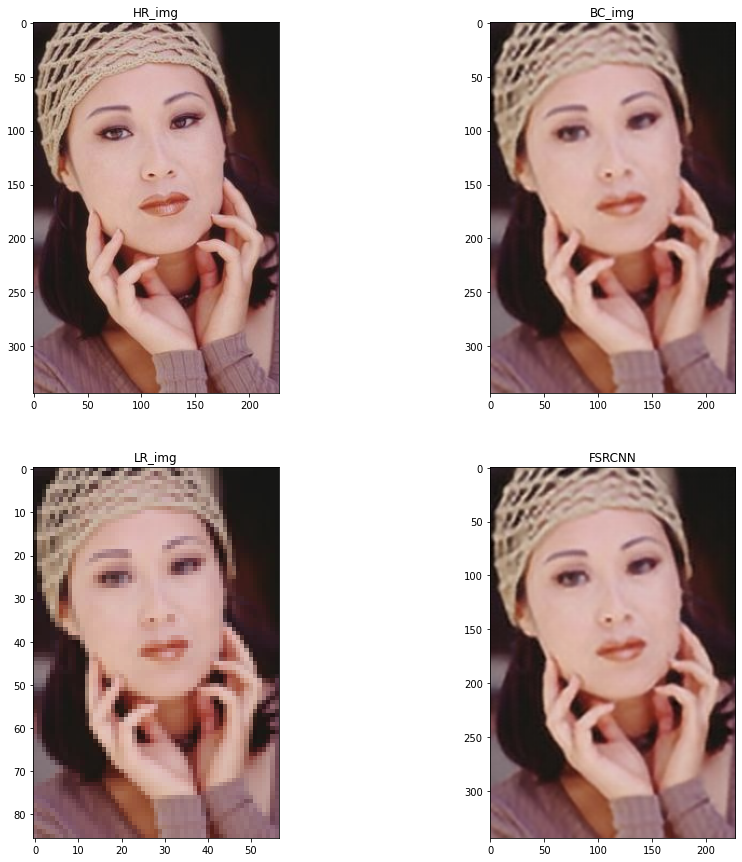

In [ ]:
def ycbcr2rgb(im): # input image : ranges from 0 to 255
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

trained_weight = torch.load("./weights/lab05/checkpoint_050.pkl")
model.load_state_dict(trained_weight['state_dict'])
model.eval()

with torch.no_grad():
    for (HR_img, LR_img, BC_img) in test_loader:
        # (1, 3, n, n)
        
        model_input = LR_img.to(device)
        model_input = model_input[0,0,:,:].reshape(1,1,LR_img.shape[2],LR_img.shape[3])
        output = model(model_input).cpu()
        FSR_img = BC_img
        FSR_img[0,0,:,:] = output.squeeze(0)
        
        HR_img = ycbcr2rgb((HR_img*255).squeeze(0).permute(1,2,0).numpy())
        BC_img = ycbcr2rgb((BC_img*255).squeeze(0).permute(1,2,0).numpy())
        LR_img = ycbcr2rgb((LR_img*255).squeeze(0).permute(1,2,0).numpy())
        FSRCNN = ycbcr2rgb((FSR_img*255).squeeze(0).permute(1,2,0).numpy())
        
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 3)
        ax4 = fig.add_subplot(2, 2, 4)
        ax1.imshow(HR_img)
        ax1.set_title("HR_img")
        ax2.imshow(BC_img)
        ax2.set_title("BC_img")
        ax3.imshow(LR_img)
        ax3.set_title("LR_img")
        ax4.imshow(FSRCNN)
        ax4.set_title("FSRCNN")
        
        plt.show()
        
        

디지털신호처리 수업에서 matlab을 사용하여 노이즈가 낀 이미지를 filter를 활용하여 이미지를 복원하는 프로그램을 구성하였었는데, 품질이 정말 좋지 못했었다.
이번 실험을 통해 CNN을 통한 super-resolution 기존의 Bicubic Interpolation과 같은 interpolation기법보다 더 좋은 성능을 낼 수 있음을 Visualization을 통해 확인할 수 있었다. 

4K, 8K를 지원하는 초고해상도 시대에서 FSRCNN을 초석으로 더 발전된 기술이 궁금했었고 실험수업 시간 마지막 슬라이드에서 여러 기술이 활용되고 있다는 것을 알 수 있어 좋았다.
추가 조사) 그 기술로는 Very Deep Super Resolution(VDSR), Enhanced Deep Super Resolution(EDSR), Super Resolution Generative Adversarial Network(SRGAN) 등 딥러닝 기반의 super-resolution기술 연구가 진행되었었다.